### SET UP AND VARIABLE DEFINITONS

In [1]:
## set up
import io
import requests
import pandas as pd
import numpy as np
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
import helper_functions.spreadsheet_specific_helpers as helper
import importlib
importlib.reload(helper)

<module 'helper_functions.spreadsheet_specific_helpers' from 'c:\\kelly\\School\\Colleage\\24-25\\seal\\gamification_data_analysis\\helper_functions\\spreadsheet_specific_helpers.py'>

In [2]:
SHEETURL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "edit?resourcekey=&gid=1780925762#gid=1780925762"
)

# format for CSV https://docs.google.com/spreadsheets/d/
# <SHEET_ID>/gviz/tq?tqx=
# out:csv&sheet=<SHEET_NAME>
SHEET_CSV_URL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "gviz/tq?tqx=out:csv&sheet=Congregated Data"
)

In [3]:

# global variables for our current data purposes
Y_COLS = [
    "On a scale of 1 - 5 how successful do you feel you are in SEAL lab?",
    "On a scale of 1 - 5, how successful to do you feel your teammates are in SEAL lab?",
    "On a scale of 1 - 5, how successful do your peers think you are in SEAL lab?",
    "On whole, how would you rate your satisfaction in SEAL lab?"
]

X_DEMO_COLS = [
    "All SEAL group affiliations",
    "Age",
    "Gender",
    "Sexual orientation",
    "Race",
    "Chronic condition",
    "Condition description",
    "Economic class",
    "Religion"
]

X_PERSONALITY_COLS = [
    "Internal / External game motivation",
    "[Introverted - Extroverted]",
    "[Critical - Trusting]",
    "[Spontaneous - Conscientious]",
    "[Self-conscious - Even-tempered]",
    "[Prefer similarity - Am open to change]"
]
MOTIVATION_COLS = [
    "Beating my competitors",
    "Mastering the game",
    "Earning the most points",
    "Working with a team",
    "Feeling immersed in the story/plot"
]

X_SEAL_COLS = [
    "I feel like I am playing a game",
    "I consider myself to be highly experienced.",
    "Aesthetically pleasing.",
    "Rank reflects work accurately.",
    "Leaderboard reflects work accurately.",
    "YBR reflects work accurately.",
    "VisTools reflects work accurately.",
    "RaceTrack reflects work accurately.",
    "Battle Station reflects work accurately.",
    "Command Center reflects work accurately.",
    "I understand what my SEAL statistics mean.",
    "I know exactly how my actions affect my lab statistics",
    "Using the Sudoku Sheet Tools helps me and my team stay on track.",
    "Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.",
    "Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable."
]
# AO:AX
X_USABILITY_COLS = [
    'I think that I would like to use this system frequently',
    'I found the system unnecessarily complex',
    'I thought the system was easy to use',
    'I think that I would need the support of a technical person to be able to use this system',
    'I found the various functions in this system were well integrated',
    'I thought there was too much inconsistency in this system',
    'I would imagine that most people would learn to use this system very quickly',
    'I found the system very cumbersome to use',
    'I felt very confident using the system',
    'I needed to learn a lot of things before I could get going with this system.']

Y_COLS = ["Personal success",
          "Teammate success",
          "Peer success",
          "Satisfaction in SEAL"
]

X_DROP_COLS = ['All SEAL group affiliations', 'Game motivation']

### Extract the data

In [4]:
def get_data() -> DataFrame:  # idealy we dont want to us Any, but for now
    """function to get the data from the google sheet
    raises: HTTPError: if the request fails (meaning url wrong or no inter)

    @returns: @type(DataFrame): the data from the google sheet"""

    response = requests.get(SHEET_CSV_URL)
    response.raise_for_status()  # Raise error if request fails
    df: DataFrame = pd.read_csv(io.StringIO(response.text))
    return df

In [5]:
## ORIGINAL
data = get_data()
columns = data.columns
print(columns)
print(data.shape) # 81 x 47


Index(['Main SEAL group affiliation', 'All SEAL group affiliations',
       'Developed for SUDOKU Sheet Tools?', 'Age', 'Gender',
       'Sexual orientation', 'Race', 'Chronic condition',
       'Condition description', 'Economic class', 'Religion',
       'Game motivation', 'Internal / External game motivation',
       '[Introverted - Extroverted]', '[Critical - Trusting]',
       '[Spontaneous - Conscientious]', '[Self-conscious - Even-tempered]',
       '[Prefer similarity - Am open to change]',
       'I feel like I am playing a game',
       'I consider myself to be highly experienced.',
       'Aesthetically pleasing.', 'Rank reflects work accurately.',
       'Leaderboard reflects work accurately.',
       'YBR reflects work accurately.', 'VisTools reflects work accurately.',
       'RaceTrack reflects work accurately.',
       'Battle Station reflects work accurately.',
       'Command Center reflects work accurately.',
       'I understand what my SEAL statistics mean.',
     

In [6]:
def split_xy(data) -> Tuple[DataFrame, DataFrame]:
    """function to split the x and y data into separate ndarrays based on
    a set of columns to be dropped

    @parameter: data @type(DataFrame): rawdata

    @returns: @type(ndarray): relevant x-values from data
    @returns: @type(ndarray): y-values from data"""
    
    split_col: DataFrame = helper.split_motivation_column(data)
    x_data = data.drop(columns=X_DROP_COLS + Y_COLS)    # split motivation columns
    x_data = pd.concat([x_data, split_col], axis=1)

    # handle X_SEAL_COLS: map disagree - agree as 1-5
    options_map = {'Strongly disagree': 1,
                    'Disagree': 2,
                    'Neutral': 3,
                    'Agree': 4,
                    'Strongly agree': 5
                    }
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)

    # Handle NaNs with data imputation of average
    x_data[X_PERSONALITY_COLS[1:]] = x_data[X_PERSONALITY_COLS[1:]].fillna(3)
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].fillna(3)
    x_data[X_USABILITY_COLS] = x_data[X_USABILITY_COLS].fillna(3)
    data[Y_COLS] = data[Y_COLS].fillna(3)

    # one-hot-encoding for categorical data (demographics, gaming)
    cat_col = x_data.select_dtypes(include=['object', 'category']).columns
    x_data = pd.get_dummies(x_data, columns = cat_col)
    y_data = data[Y_COLS]
    return x_data, y_data

In [7]:
x_data, y_data = split_xy(data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state = 12)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(68, 90) (68, 4)
(13, 90) (13, 4)


C:\Users\kelly\AppData\Local\Temp\ipykernel_3220\3779065999.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)


In [8]:
def standardize(x_train, x_test) -> Tuple[DataFrame, DataFrame]:
    """function that standardizes data to normal gaussian distribution.
    Standardization calculation is applied only to the training data.

    @parameter: x_train @type(nd.array) processed x training data to be standardized
    @paremeter: x_test @type(nd.array) processed x-test data to be standardized
    """
    scaler = StandardScaler().fit(x_train)  # only fit on training data
    x_train_stand = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test_stand = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train_stand, x_test_stand

In [9]:
x_train, x_test = standardize(x_train, x_test)
print(x_train.shape)


(68, 90)


c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019458841041437913, tolerance: 0.01689090909090908
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017907362722911768, tolerance: 0.01429074074074074
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018999884016906554, tolerance: 0.01501818181818182
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_

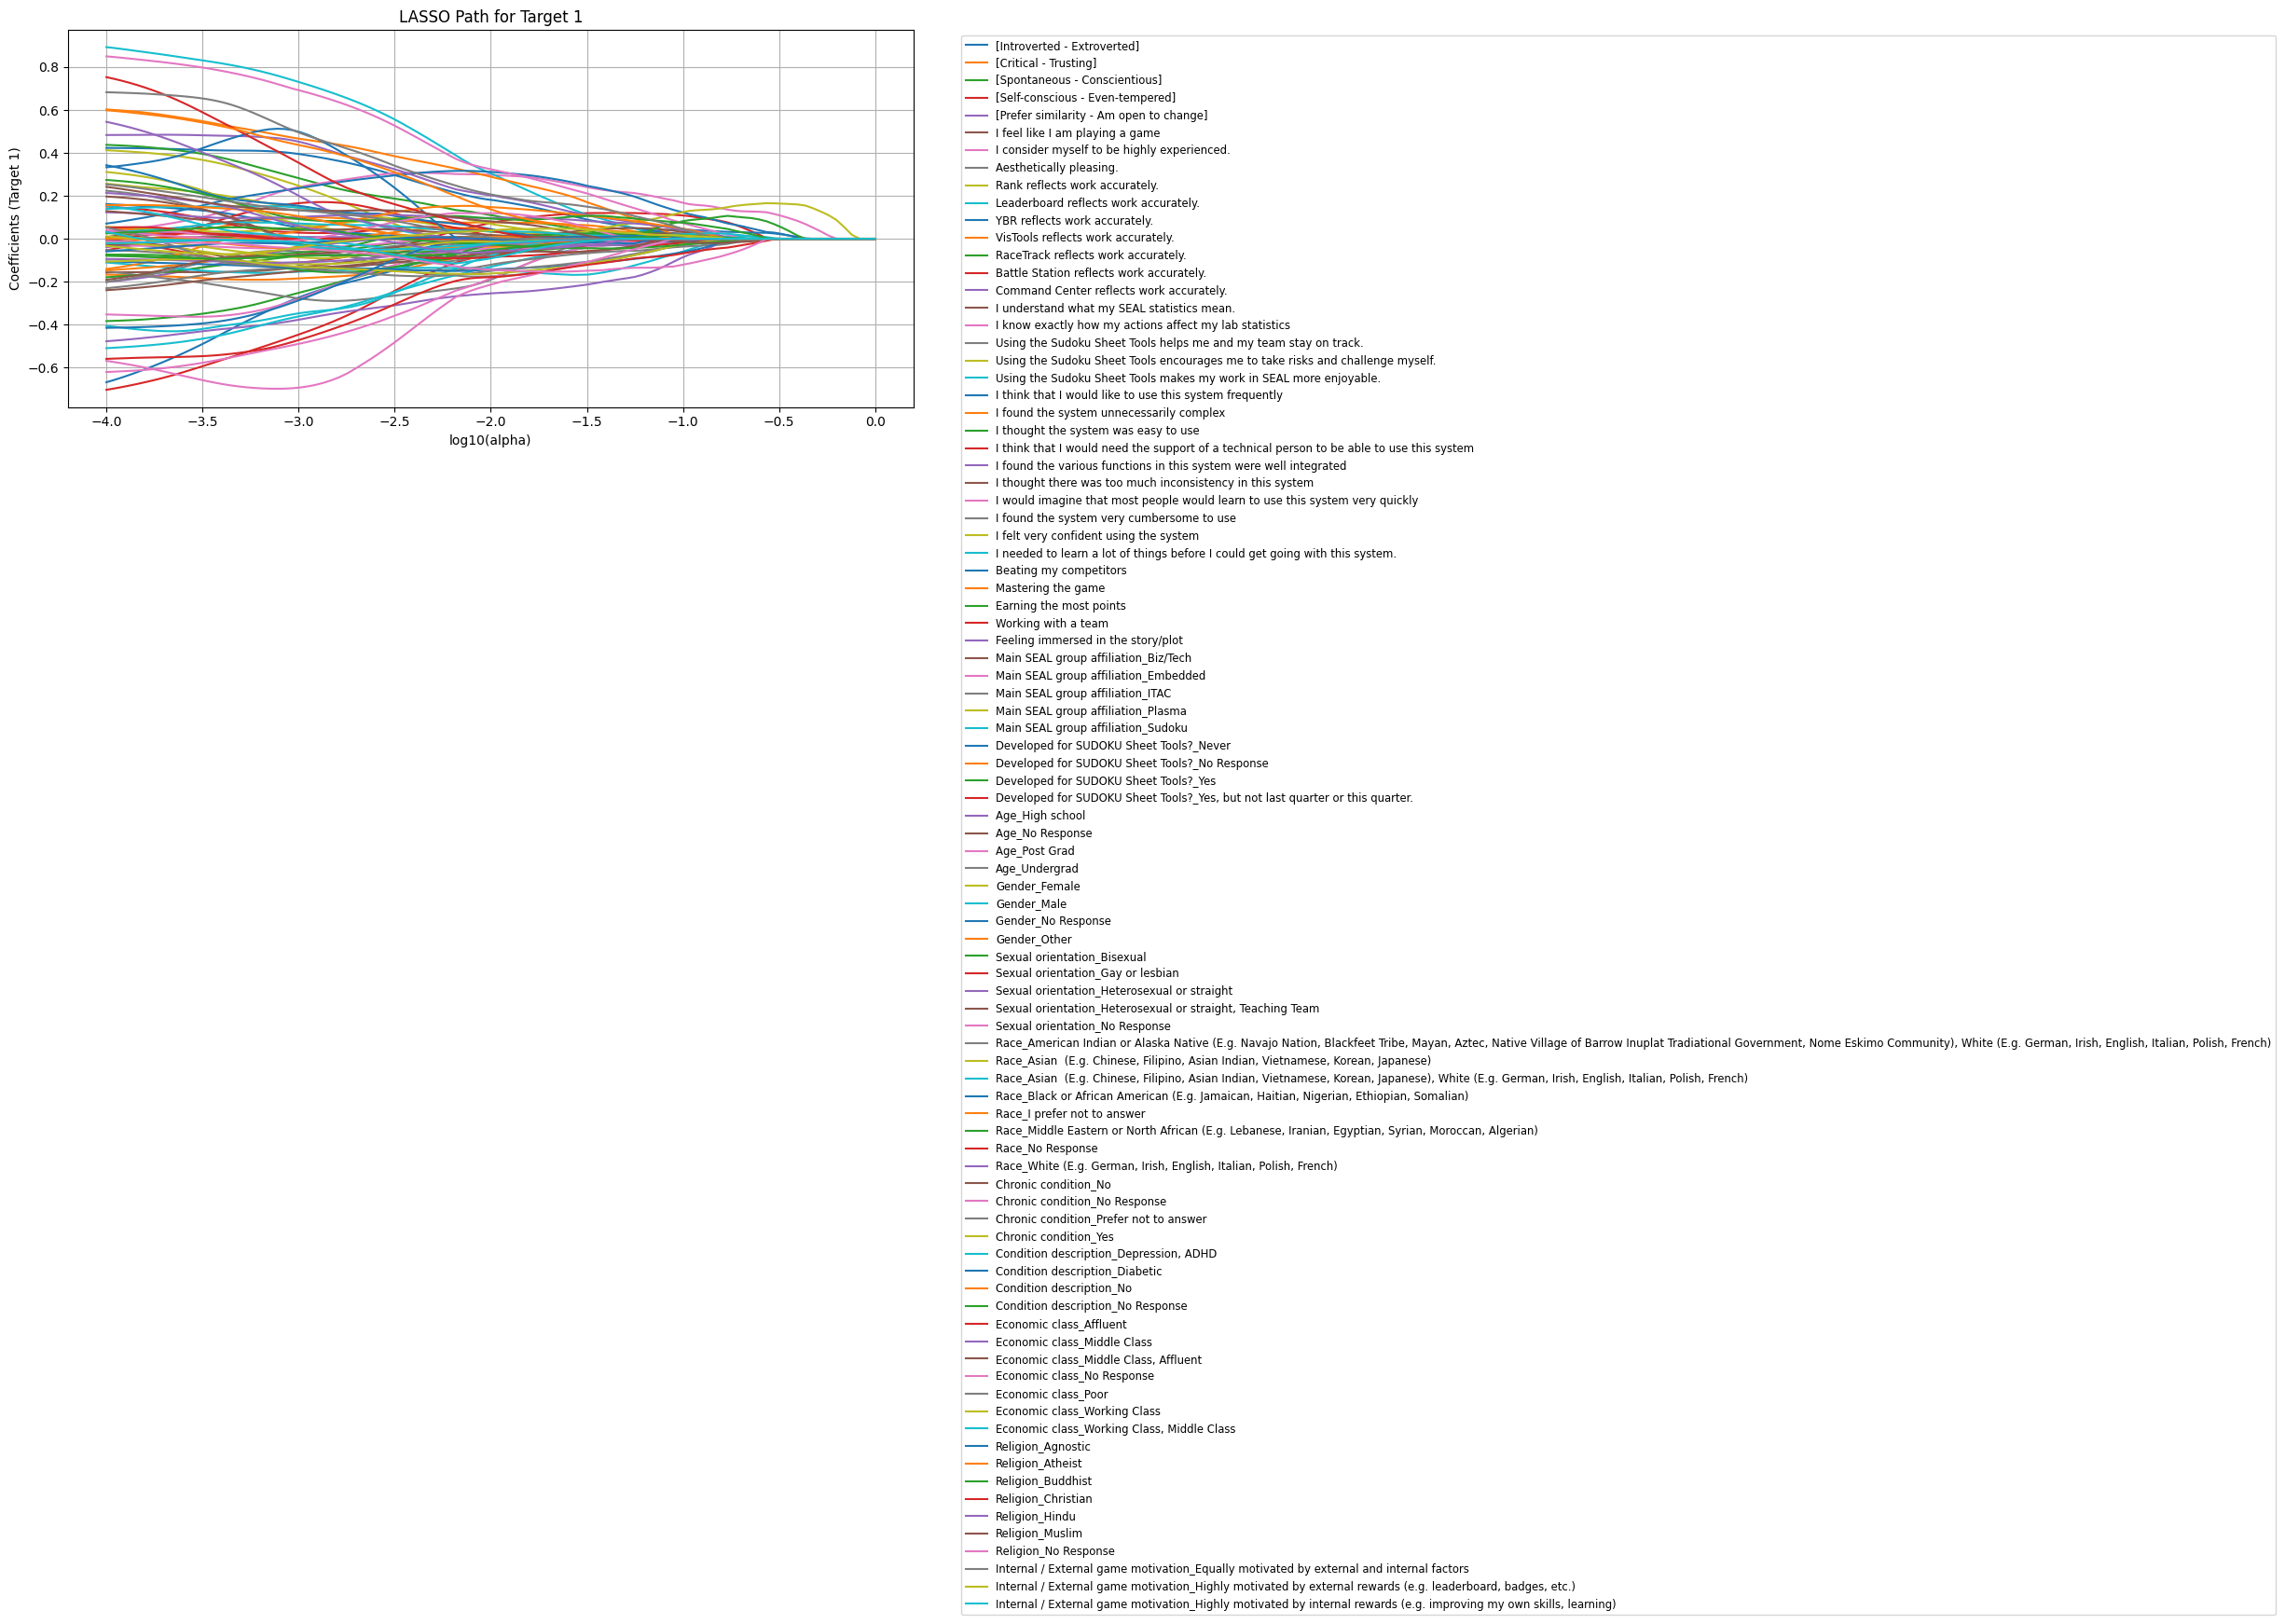

c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019458841041437913, tolerance: 0.01689090909090908
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017907362722911768, tolerance: 0.01429074074074074
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018999884016906554, tolerance: 0.01501818181818182
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_

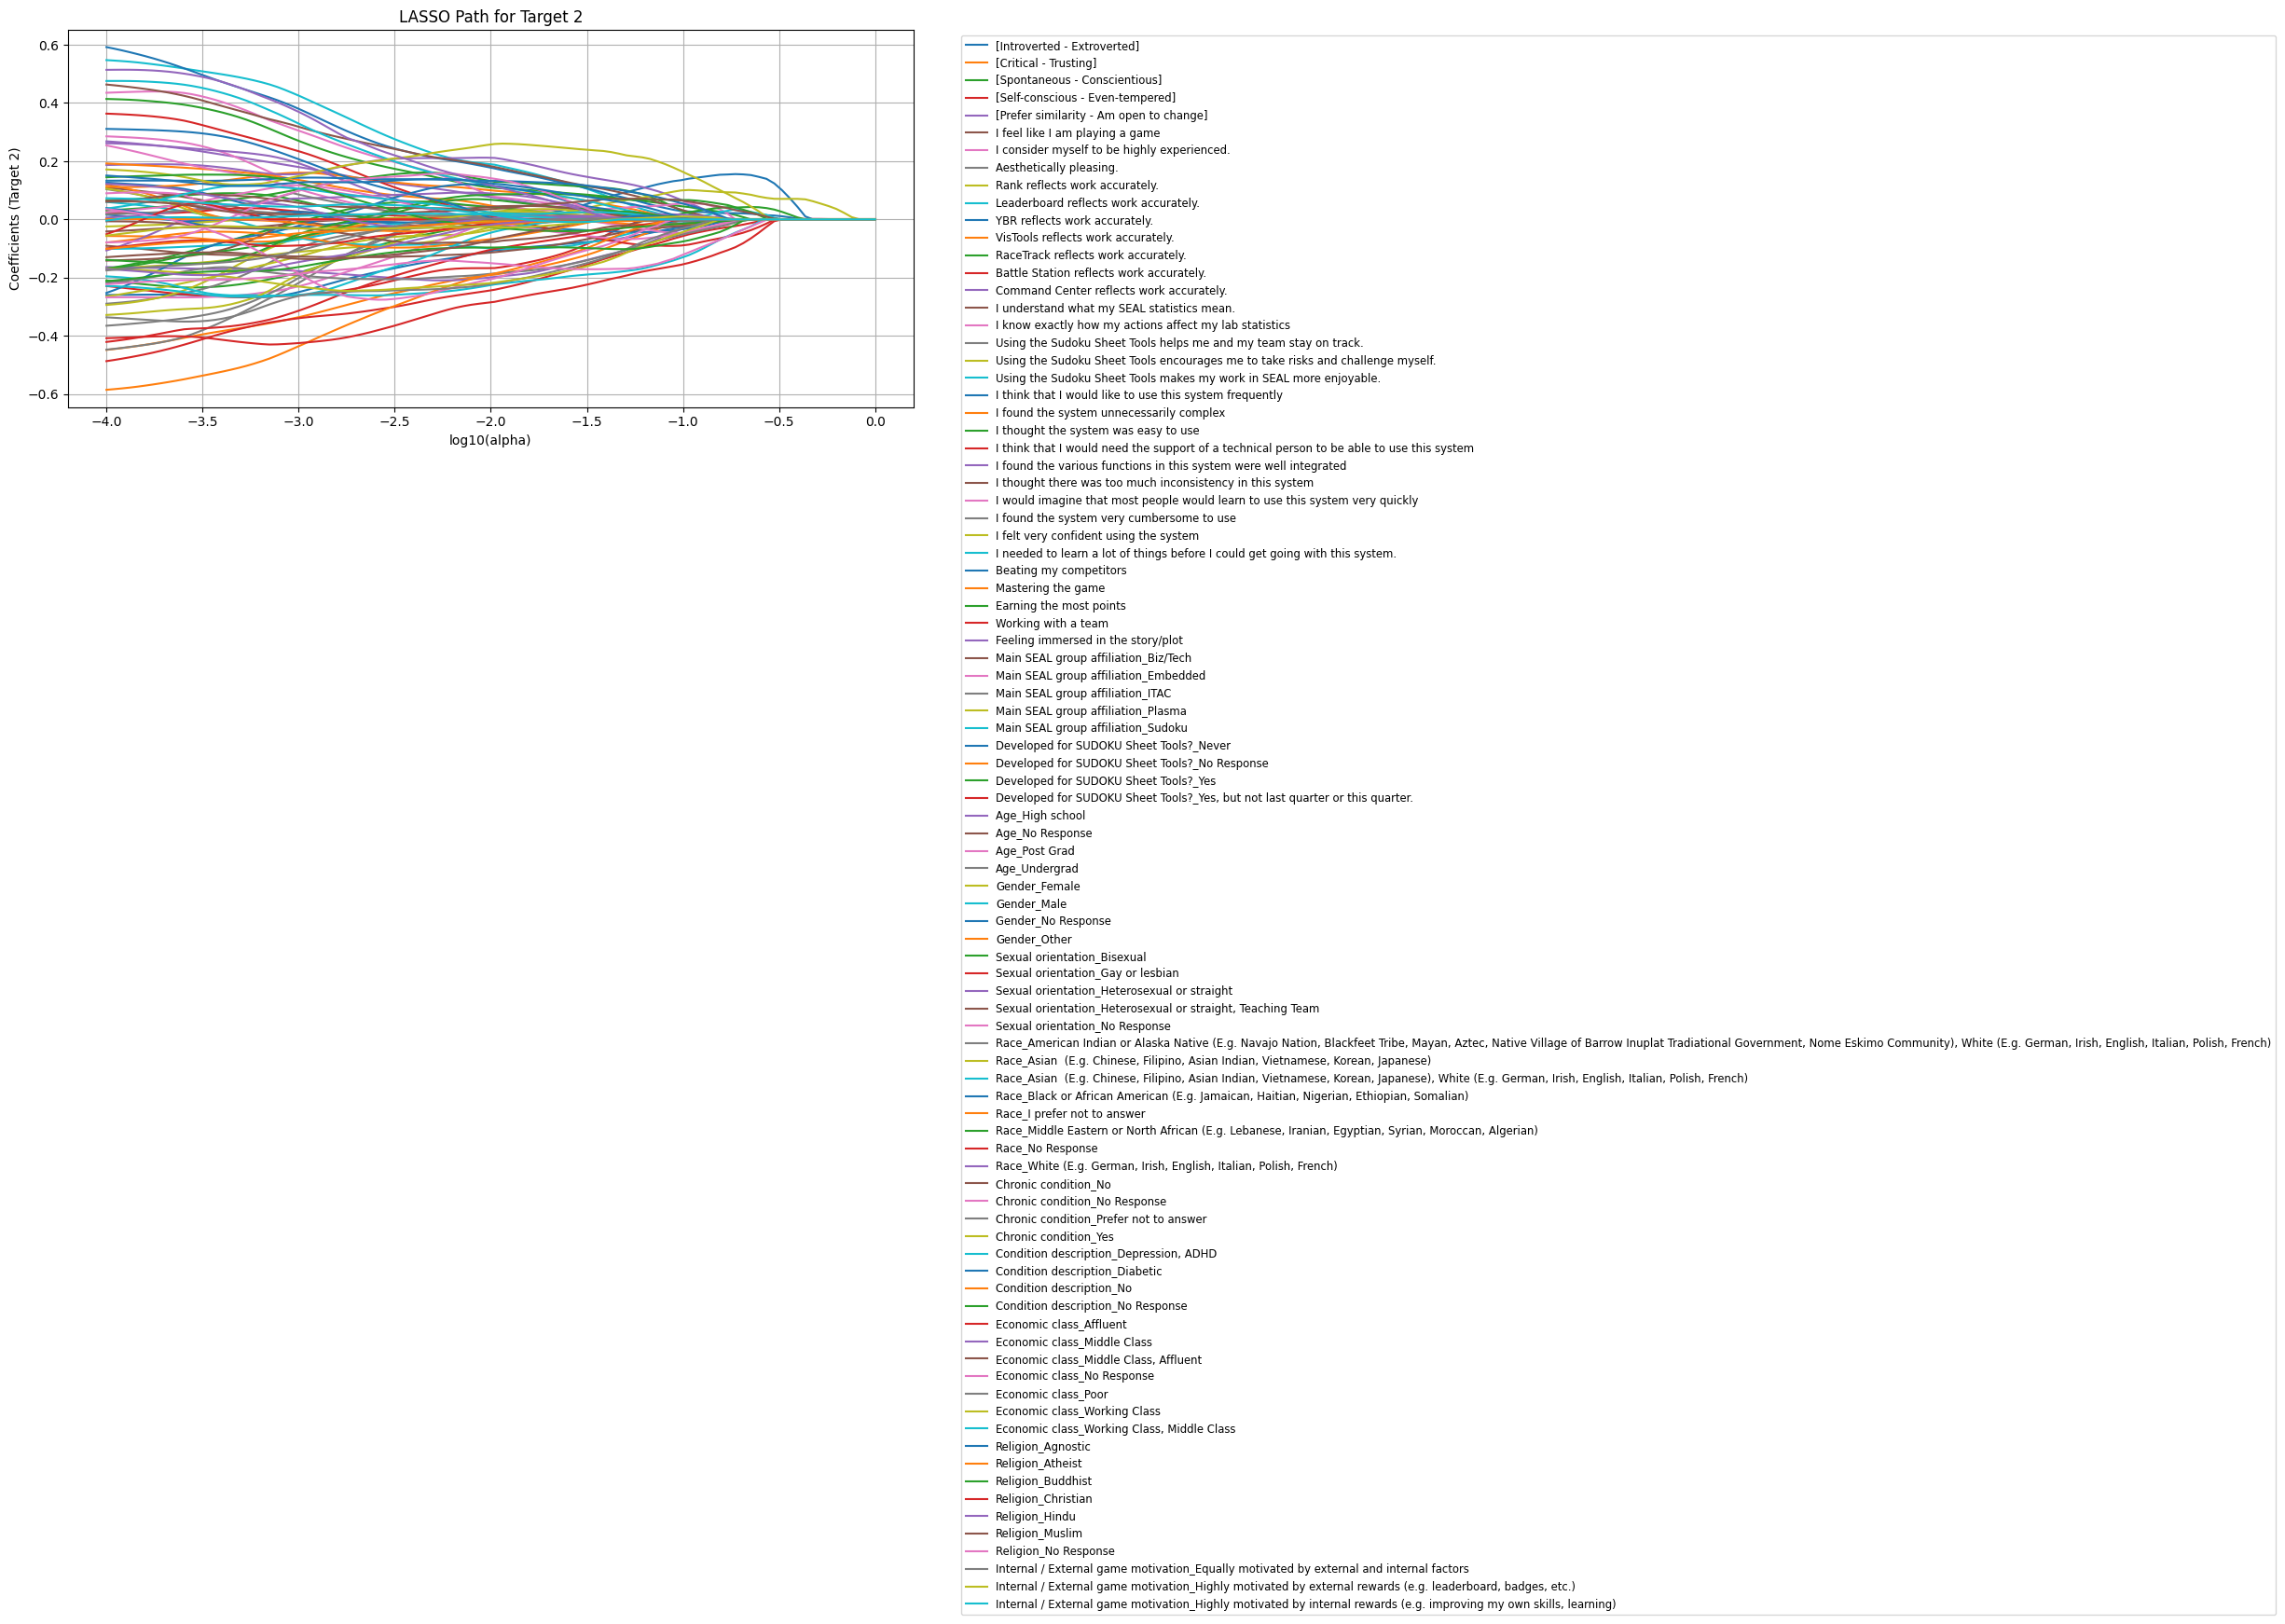

c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019458841041437913, tolerance: 0.01689090909090908
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017907362722911768, tolerance: 0.01429074074074074
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018999884016906554, tolerance: 0.01501818181818182
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_

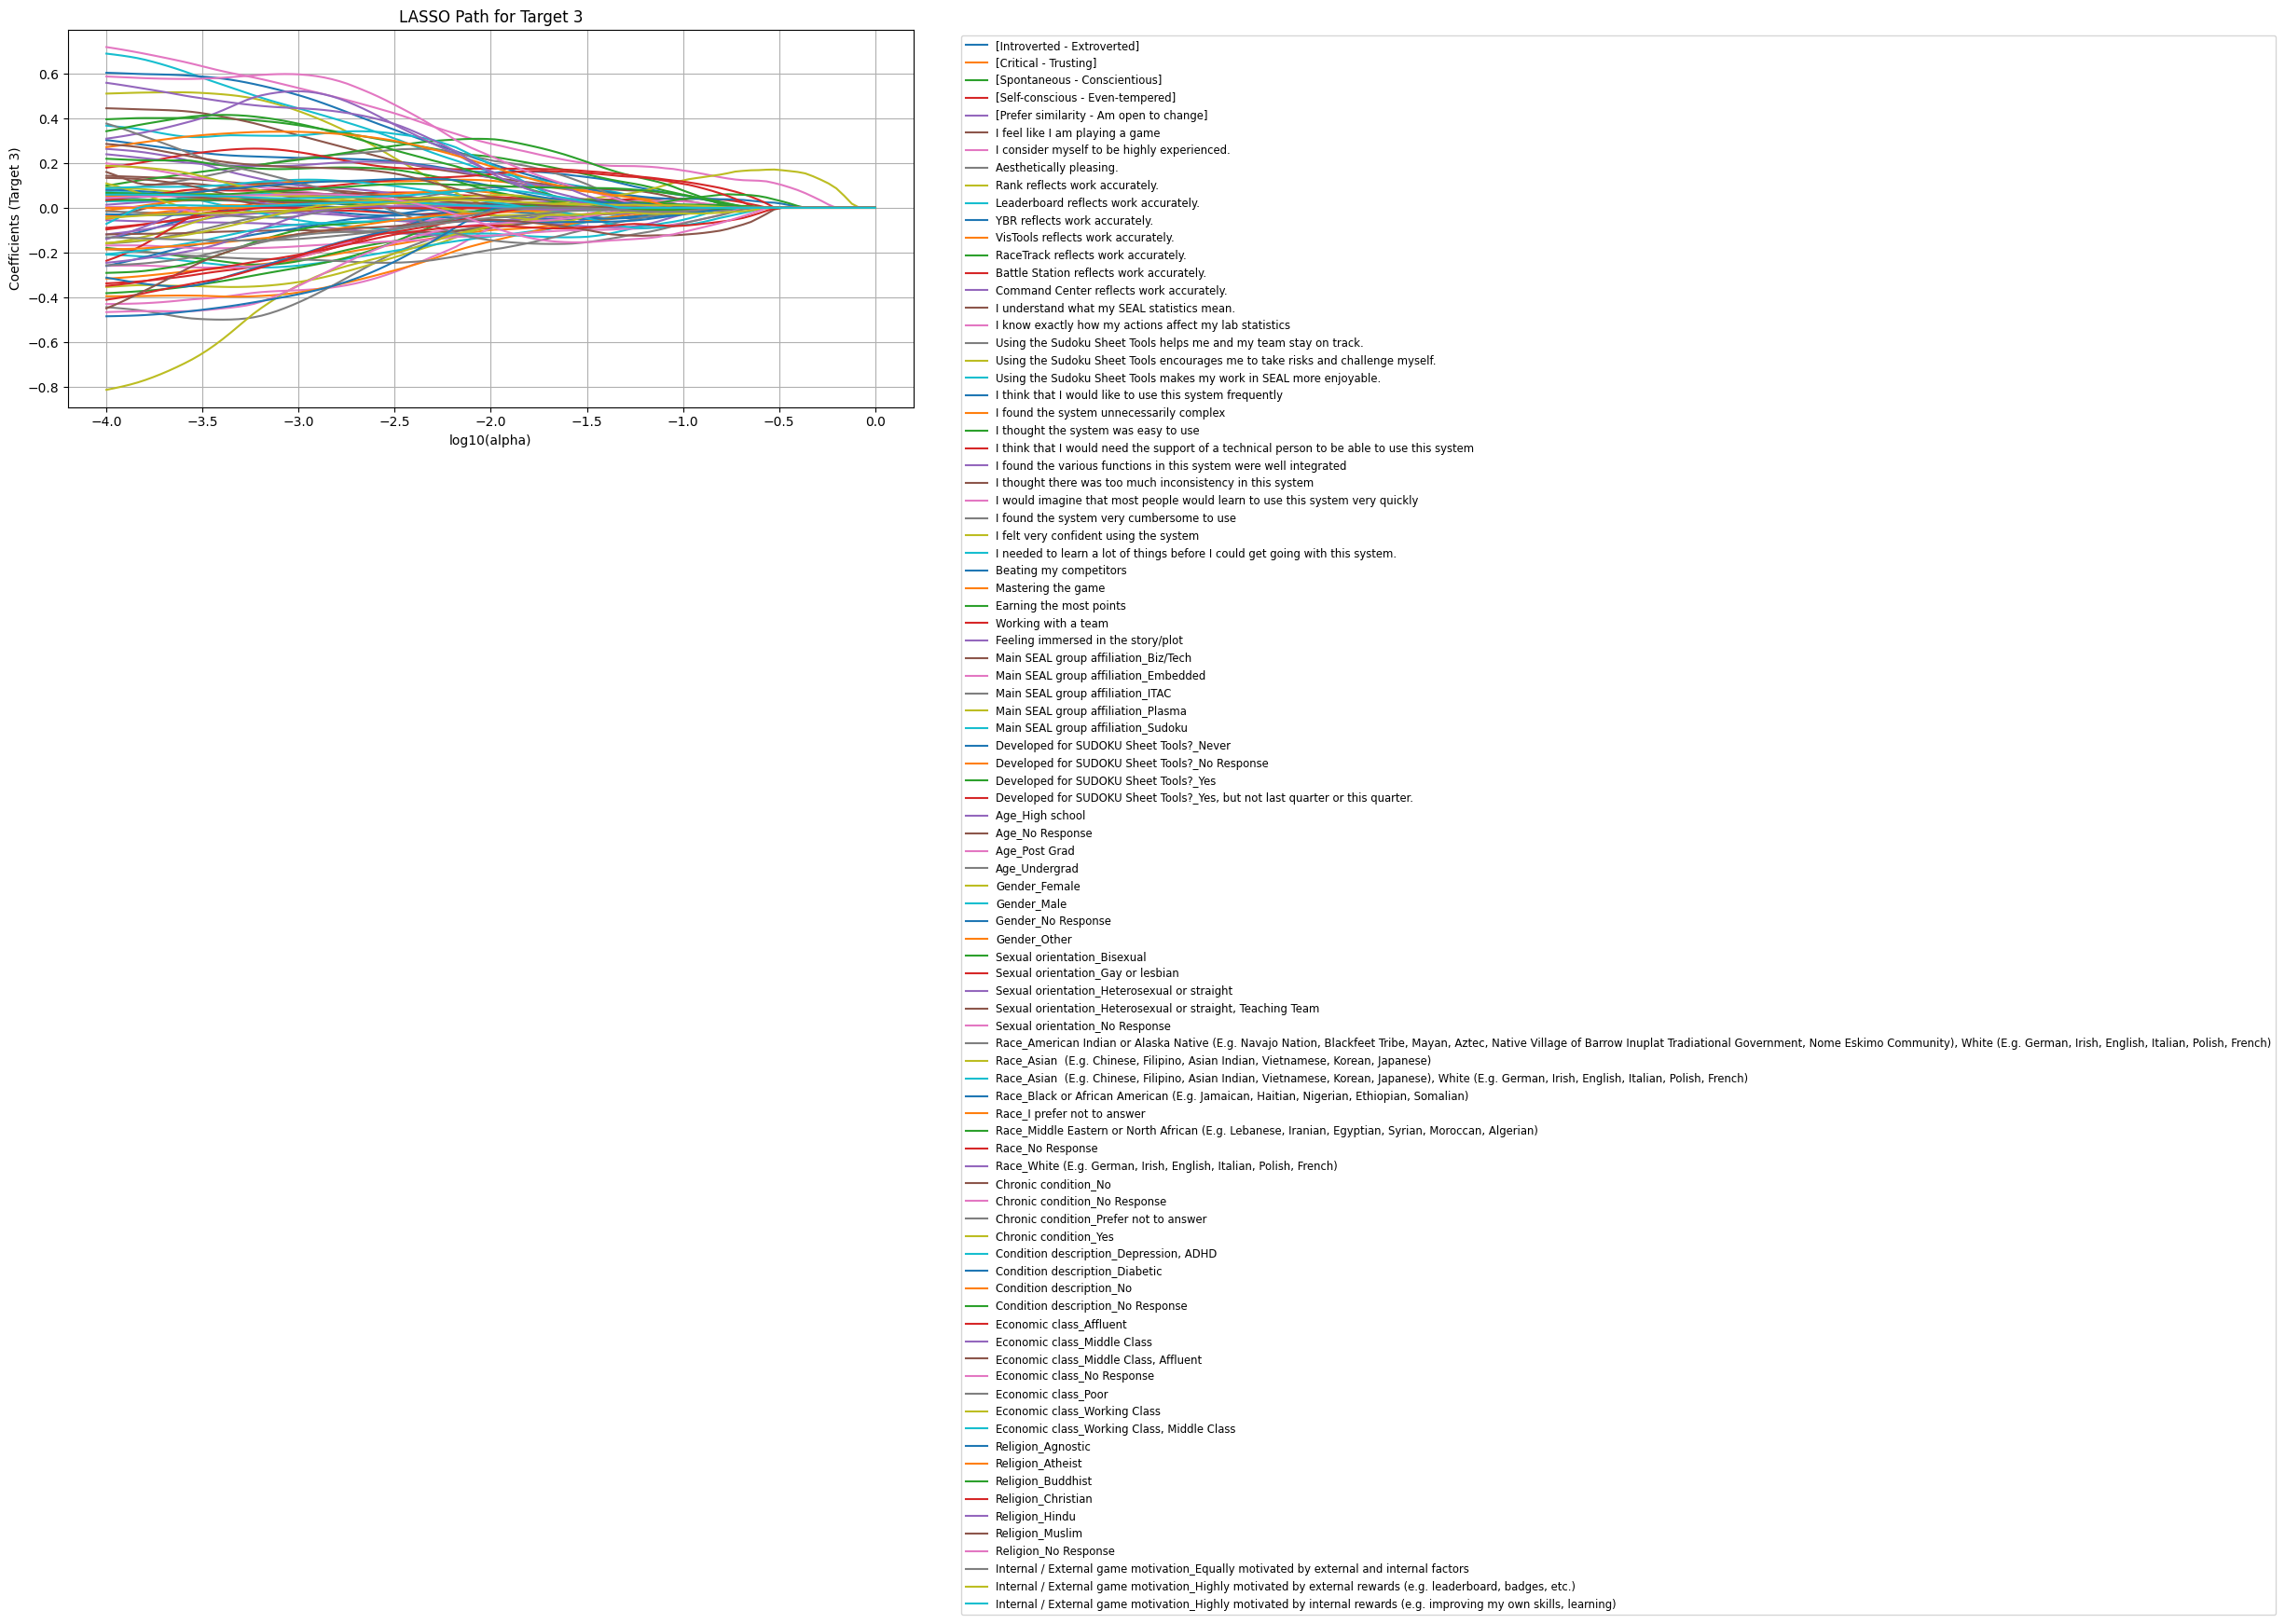

c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019458841041437913, tolerance: 0.01689090909090908
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017907362722911768, tolerance: 0.01429074074074074
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018999884016906554, tolerance: 0.01501818181818182
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_

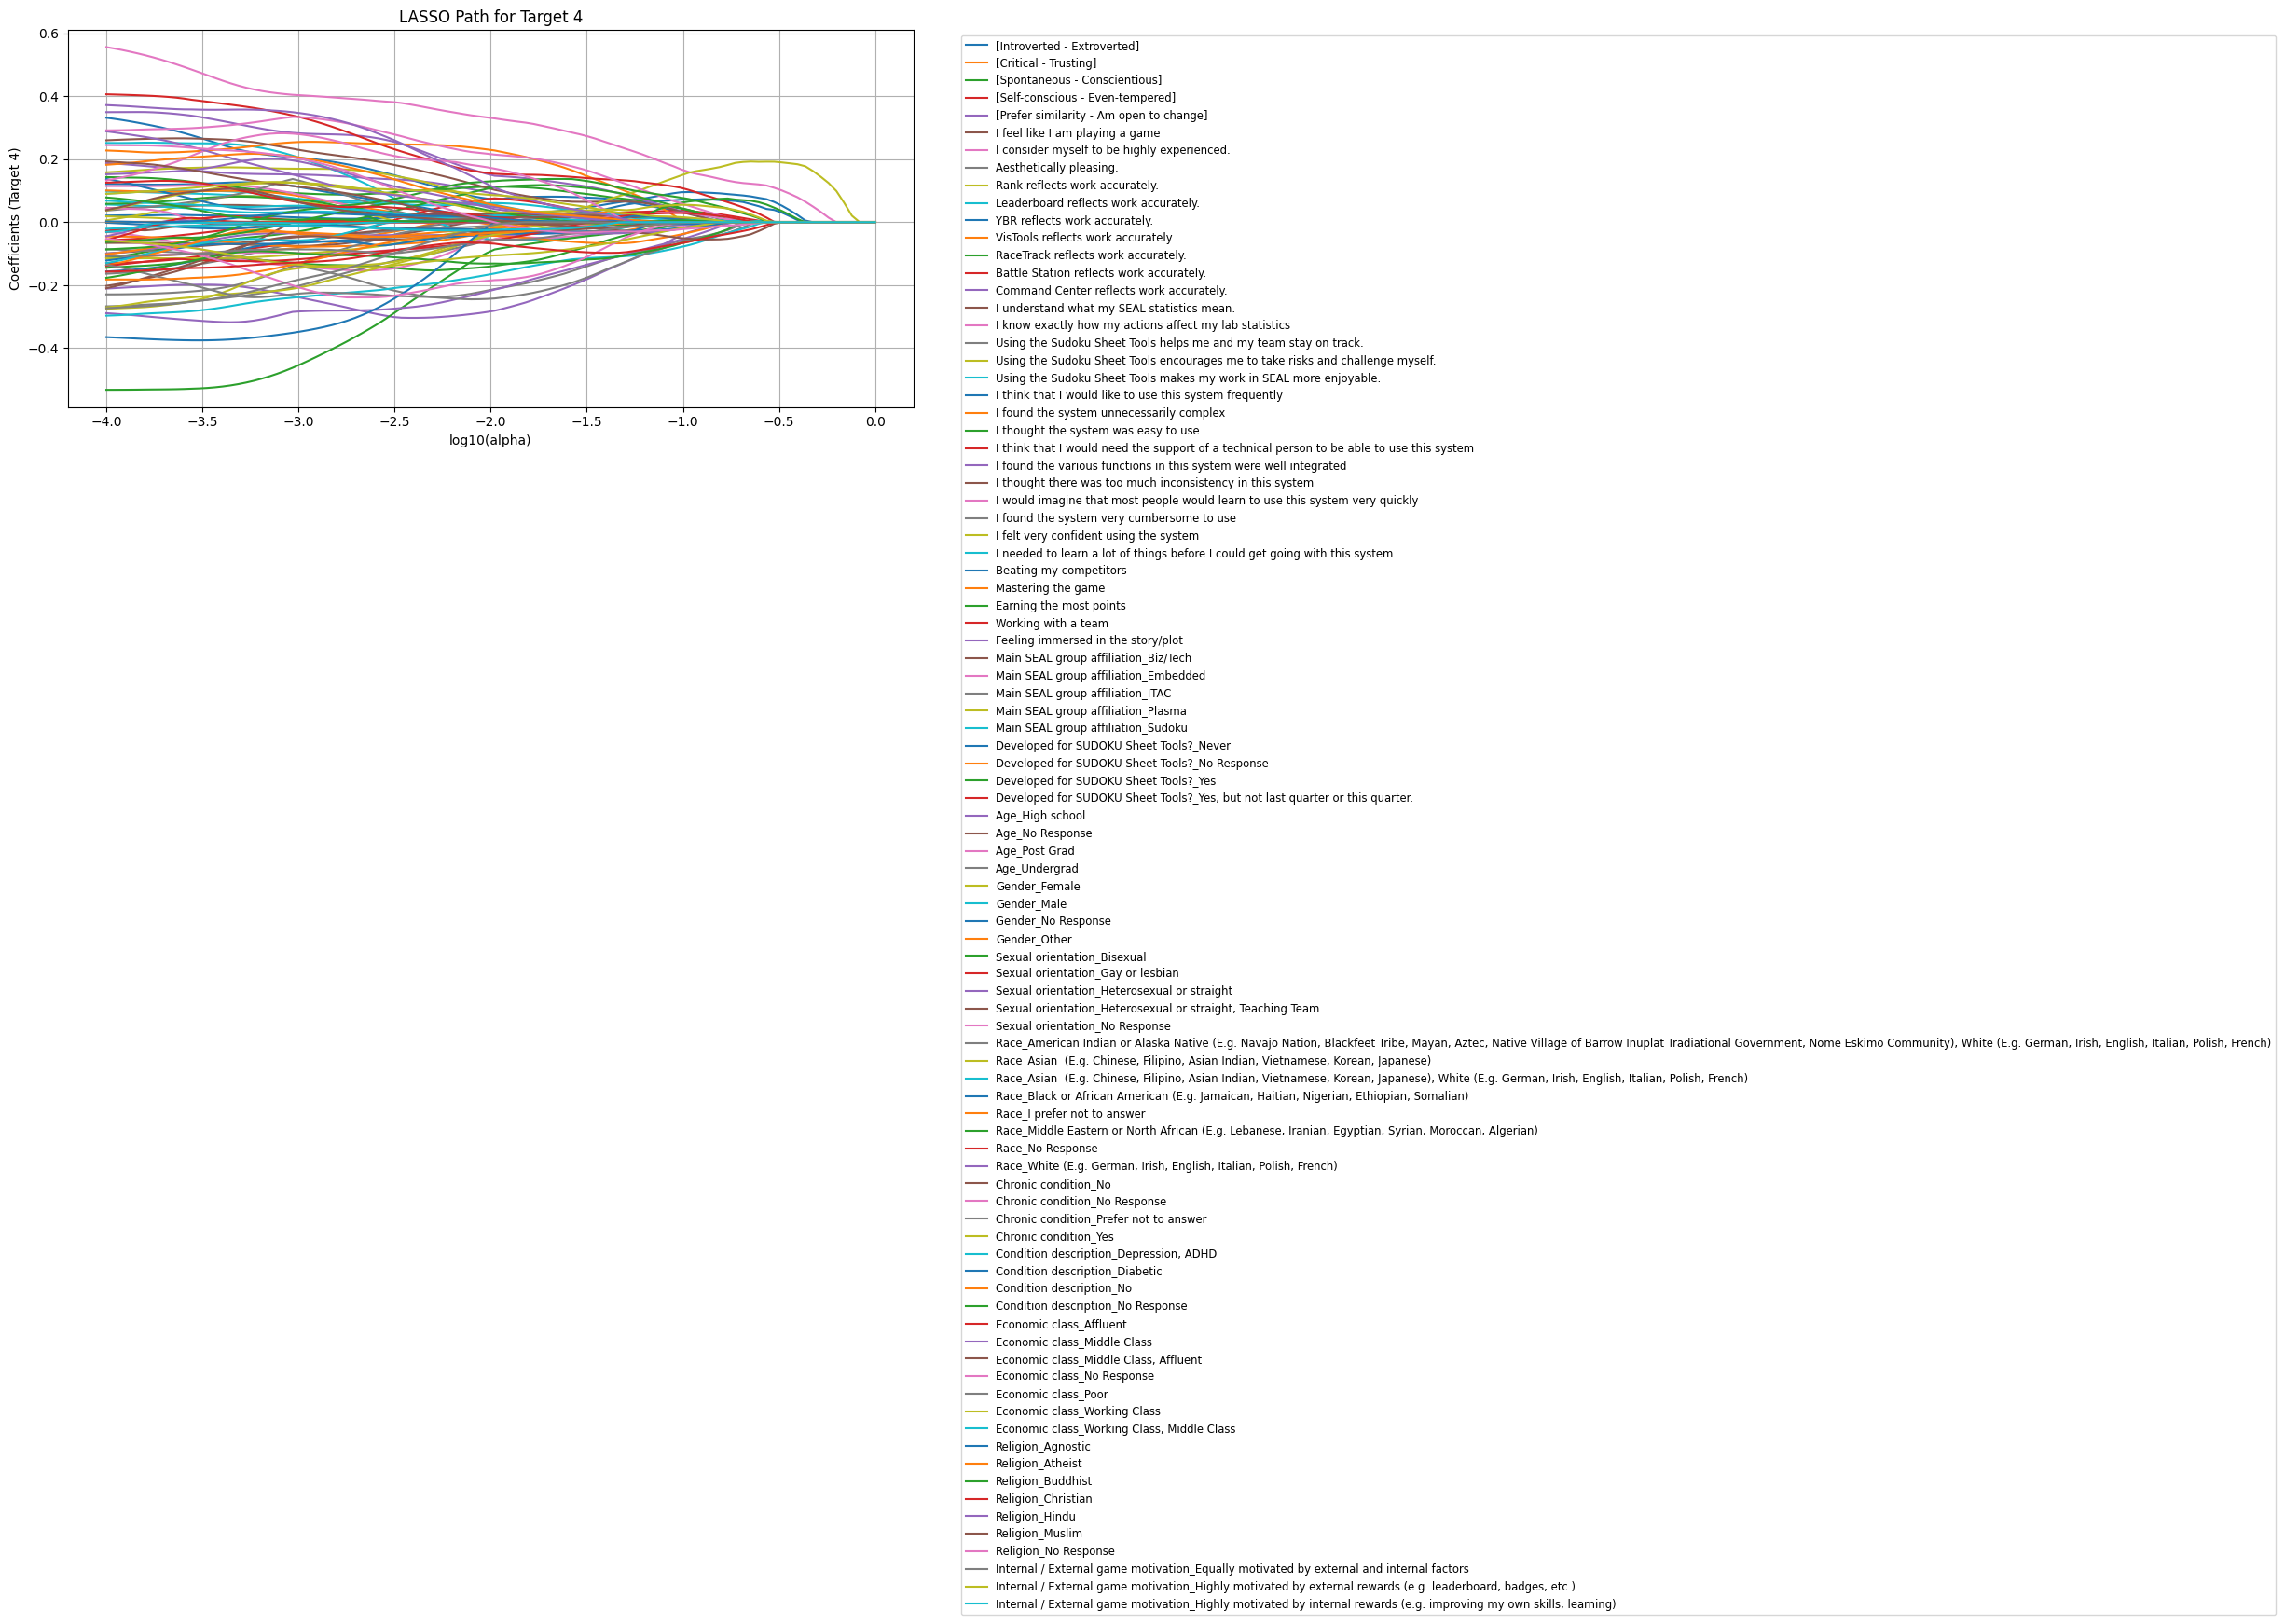

In [13]:
def plot_multitask_lasso_path(x_train, y_train):
    lasso_cv = MultiTaskLassoCV(alphas=np.logspace(-4, 0, 100), cv=5, random_state=12)
    lasso_cv.fit(x_train, y_train)

    # lasso_cv.coef_ is shape (n_targets, n_features)
    # To plot, we show coefficient magnitudes across alphas for each target separately

    alphas = lasso_cv.alphas_
    n_targets = y_train.shape[1]

    for task_idx in range(n_targets):
        coefs = []
        for alpha in alphas:
            lasso = MultiTaskLassoCV(alphas=[alpha], cv=5, random_state=12)
            lasso.fit(x_train, y_train)
            coefs.append(lasso.coef_[task_idx])

        coefs = np.array(coefs)
        plt.figure(figsize=(10, 5))
        for i in range(coefs.shape[1]):
            plt.plot(np.log10(alphas), coefs[:, i], label=x_train.columns[i])

        plt.xlabel("log10(alpha)")
        plt.ylabel(f"Coefficients (Target {task_idx+1})")
        plt.title(f"LASSO Path for Target {task_idx+1}")
        plt.grid(True)
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.show()
plot_multitask_lasso_path(x_train, y_train)


In [44]:
def feature_selection(x_train, y_train):
    """function to apply LASSO regression on training data to select optimal
    features.

    @parameter: x_train @type(nd.array) standardized x_train data
    @parameter: y_train @type(nd.array) y_train data"""

    # perform 5-fold cross validation on lasso values
    lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 0, 100), cv=5, random_state=12)
    lasso.fit(x_train, y_train)
    best_l1 = lasso.alpha_
    non_zero_indices = np.abs(lasso.coef_) >= 1e-8

    top_features = []
    eliminated_features = []

    for i, feature in enumerate(x_train.columns):
        if np.any(non_zero_indices[:, i]):
            top_features.append(feature)
        else:
            eliminated_features.append(feature)
    return x_train[top_features], best_l1, eliminated_features, top_features

In [45]:
x_train_reduced, l1, eliminated_features, top_features = feature_selection(x_train, y_train)
print(l1)
print(f'eliminated {len(eliminated_features)} {eliminated_features}')
print(f'kept {len(top_features)} {top_features}')
x_test_reduced = x_test[top_features]

0.1873817422860385
eliminated 66 ['[Critical - Trusting]', '[Spontaneous - Conscientious]', '[Prefer similarity - Am open to change]', 'I feel like I am playing a game', 'Aesthetically pleasing.', 'Rank reflects work accurately.', 'Leaderboard reflects work accurately.', 'VisTools reflects work accurately.', 'Battle Station reflects work accurately.', 'Command Center reflects work accurately.', 'I understand what my SEAL statistics mean.', 'I know exactly how my actions affect my lab statistics', 'Using the Sudoku Sheet Tools helps me and my team stay on track.', 'Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.', 'Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable.', 'I found the system unnecessarily complex', 'I thought the system was easy to use', 'I think that I would need the support of a technical person to be able to use this system', 'I found the various functions in this system were well integrated', 'I thought there was too much in

In [12]:
def linear_regression(x_train, y_train, x_val, y_val):
    models = []
    train_rmse = []
    val_rmse = []
    for i in range(y_train.shape[1]):
        y_t = y_train.iloc[:,i]
        y_v = y_val.iloc[:,i]
        model = LinearRegression().fit(x_train, y_t)
        predict_t = model.predict(x_train)
        t_rmse = np.sqrt(mean_squared_error(y_t, predict_t))
        predict_v = model.predict(x_val)
        v_rmse = np.sqrt(mean_squared_error(y_v, predict_v))

        train_rmse.append(t_rmse)
        val_rmse.append(v_rmse)
        models.append(model)
    print(x_train.columns)
    linear_visualization(models, x_train.columns, y_train.columns)
    return models, train_rmse, val_rmse

def linear_visualization(models, features, y_cols):
    for i, model in enumerate(models):
        coef = model.coef_

        coef_list = pd.DataFrame({"Feature": features, "Coef": coef})
        coef_list["abs"] = coef_list["Coef"].abs()
        top = coef_list.nlargest(10, "abs")
        print(top["Feature"], top["Coef"])

        plt.figure(figsize = (10,5))
        plt.barh(top["Feature"], top["Coef"])
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Features")
        plt.ylabel("Coef values")
        plt.title(f"{y_cols[i]}")
        plt.show()